# **Classification of the "Intel Image Classification" Dataset**

We Start by importing the needed libraries

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
from time import perf_counter

from random import randint as rand
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import v2
from torchvision.io import read_image
from torch.utils.data import DataLoader, Dataset

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
path = Path("./Data/seg_train/seg_train")

train_img = []
train_targets = []

for folder in path.iterdir():
    for file in folder.iterdir():
        train_img.append(v2.Resize((150,150))(read_image(str(file))))
        train_targets.append(folder.name)

In [4]:
train_img = torch.stack(train_img)

In [5]:
target_dict = np.unique(train_targets)
train_targets = torch.tensor([np.where(target_dict == target)[0][0] for target in train_targets])

In [6]:
class ImageDataset(Dataset):
    def __init__(self, img, targets):
        self.img = img.clone().detach().to(device).to(torch.float32)
        self.targets = targets.clone().detach().to(device).to(torch.float32)

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        img = self.img[idx]
        target = self.targets[idx]
        return img, target

In [7]:
train_data = ImageDataset(train_img, train_targets)

In [8]:
train_img.shape

torch.Size([14034, 3, 150, 150])

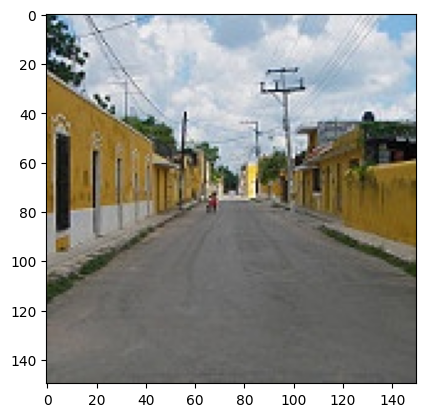

In [9]:
r = rand(0, len(train_img))
plt.imshow(v2.ToPILImage()(train_img[r]))
plt.show()

In [10]:
r

11771

In [11]:
train_targets[r]

tensor(5)

Data targets:

0. buildings
1. forest
2. glacier
3. mountain
4. sea
5. street

In [12]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # Input size - Kernel size / Stride + 1 = Output size (6,146,146)
        self.pool = nn.MaxPool2d(2, 2) # Divide the size by 2 (6,73,73)
        self.conv2 = nn.Conv2d(6, 16, 5) # (16,69,69) -> (16,34,34) (Because of the pooling layer (again)) -> Flatten (16*34*34) = 18496
        
        #Dense layers
        
        self.fc1 = nn.Linear(16 * 34 * 34, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 6)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
model = Model()
model.to(device)

Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=18496, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [14]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [15]:
train_data.img.dtype

torch.float32

In [16]:
train_data.targets.dtype

torch.float32

In [17]:
loader = DataLoader(train_data, batch_size=4, shuffle=True)

epoch = 75
time_start = perf_counter()
for e in range(epoch):
    for i, (train_img, target) in enumerate(loader):
        target = target.long()
        optimizer.zero_grad()
        output = model(train_img)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch: {e}, Loss: {loss}")
time_end = perf_counter()
print(f"Time taken: {time_end - time_start}")

Epoch: 0, Loss: 0.63896644115448
Epoch: 1, Loss: 0.17595720291137695
Epoch: 2, Loss: 1.1167300939559937
Epoch: 3, Loss: 0.22874632477760315
Epoch: 4, Loss: 0.0013601341051980853
Epoch: 5, Loss: 0.00021460026619024575
Epoch: 6, Loss: 7.885173545219004e-05
Epoch: 7, Loss: 0.00354668777436018
Epoch: 8, Loss: 1.1472567319869995
Epoch: 9, Loss: 0.10806980729103088
Epoch: 10, Loss: 0.0322863943874836
Epoch: 11, Loss: 0.0
Epoch: 12, Loss: 1.1920915312657598e-06
Epoch: 13, Loss: 0.0
Epoch: 14, Loss: 5.9604641222676946e-08
Epoch: 15, Loss: 0.0040520308539271355
Epoch: 16, Loss: 0.0001211022463394329
Epoch: 17, Loss: 5.006773790228181e-06
Epoch: 18, Loss: 0.00021692262089345604
Epoch: 19, Loss: 0.0005624110344797373
Epoch: 20, Loss: 0.00014475875650532544
Epoch: 21, Loss: 1.3947304978501052e-05
Epoch: 22, Loss: 4.7683693082944956e-07
Epoch: 23, Loss: 0.0
Epoch: 24, Loss: 0.00026147678727284074
Epoch: 25, Loss: 0.0
Epoch: 26, Loss: 3.4986776881851256e-05
Epoch: 27, Loss: 1.5914187315502204e-05
Ep

In [18]:
def predict(img):
    return target_dict[torch.argmax(model(img)).item()]

In [22]:
accuracy = 0
for i in range(10000):
    r = rand(0, len(train_data.img)-1)
    if predict(train_data.img[r].unsqueeze(0)) == target_dict[int(train_data.targets[r])]:
        accuracy += 1

In [23]:
print(f"Accuracy: {accuracy/10000*100}%")

Accuracy: 99.97%


Epochs / Accuracy: 

- 10 : 18%
- 30 : 30%
- 50 : 60%
- 100 : 70%
- 150 : 18%

In [25]:
path = Path("./Data/seg_test/seg_test")

test_img = []
test_targets = []

for folder in path.iterdir():
    for file in folder.iterdir():
        test_img.append(v2.Resize((150,150))(read_image(str(file))))
        test_targets.append(folder.name)

In [26]:
test_data = ImageDataset(torch.stack(test_img), torch.tensor([np.where(target_dict == target)[0][0] for target in test_targets]))

In [34]:
preds = []
for img in test_data.img:
    preds.append(predict(img.unsqueeze(0)))
accuracy = sum([1 for i in range(len(preds)) if preds[i] == target_dict[int(test_data.targets[i])]])/len(preds)*100

In [35]:
accuracy

73.6